# Setup

In [90]:
# -*- coding: utf-8 -*-
%matplotlib inline

import agate
import warnings
import requests
import zipfile
import io
import json
import unicodedata

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import locale
import arrow
import xml.etree.ElementTree as ET

from locale import atof
from dateutil import parser
from datetime import datetime

plt.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 10

warnings.filterwarnings('ignore')


# Trump Tweet analysis

A look at Trump's tweets since inauguration day.

## Questions to answer

### Data processing

* Date grouping columns
* Sentiment analysis

### Analysis

* Frequencies sliced several ways: By day, month, hour of day
* Rates: Tweets/day, Tweets/day/month
* Retweets: What was shared heavily?
* Searches: 
  * Media organizations

# Get data

_Only run this if you need to update the Trump tweet data, for example the first time you run this script._

First, download the zipfile and unzip it in `data` directory.

**@TODO**: Cache zip files locally, read from zip into ignored local file.

In [91]:
response = requests.get('https://github.com/bpb27/trump_tweet_data_archive/raw/master/master_2017.json.zip')
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall('data')

Open the downloaded, unzipped JSON file, run sentiment analysis, remove multi-valued `entities` field, and create `data/master_2017_processed.json`.

In [92]:
with open('data/master_2017.json') as f:
    jsondata = json.load(f)

analyzer = SentimentIntensityAnalyzer()
for row in jsondata:
    del(row['entities'])
    vs = analyzer.polarity_scores(row['text'])
    row['sentiment'] = vs

with open('data/master_2017_processed.json', 'w') as f:
    json.dump(jsondata, f)

# Utilities

_Add helper functions here._

In [93]:
# Stub for helpers
# convert utc to est
def convertUTCtoFull(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('dddd, MMM D, YYYY h:mm A')

# convert to month
def convertUTCtoMonth(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('MM')

# convert to day
def convertUTCtoDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('D')

# convert to month/day
def convertUTCtoMonthDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('YYYY-MM-DD')

# convert to day of week
def convertUTCtoDayOfWeek(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('d')

# convert to time
def convertUTCtoHourOfDay(date):
    utc = arrow.get(date)
    return int(utc.to('US/Eastern').format('HH'))

# convert to week of year
def convertUTCtoWeekNumber(date):
    return int(date.strftime('%U'))

# Strip HTML
def stripHTML(html):
    tree = ET.fromstring(html)
    return ET.tostring(tree, encoding='utf8', method='text')

# Encode with closest thing to character
def encodeText(line):
    line = unicodedata.normalize('NFKD', line).encode('ascii','ignore')
    return line

# Data processing

Open the `json` file and then use the `json_normalize()` function to flatten it for use with Pandas, which doesn't like nested json.

In [94]:
with open('data/master_2017_processed.json') as f:
    jsondata = json.load(f)
normalized_json = pd.io.json.json_normalize(jsondata)
tweets = pd.DataFrame(normalized_json)
tweets['created_date'] = pd.to_datetime(tweets['created_at'])

Add many time grouping columns.

In [95]:
tweets['human_date'] = tweets['created_date'].apply(convertUTCtoFull)
tweets['month/day'] = tweets['created_date'].apply(convertUTCtoMonthDay)
tweets['month'] = tweets['created_date'].apply(convertUTCtoMonth)
tweets['day'] = tweets['created_date'].apply(convertUTCtoDay)
tweets['day of week'] = tweets['created_date'].apply(convertUTCtoDayOfWeek)
tweets['hour'] = tweets['created_date'].apply(convertUTCtoHourOfDay)
tweets['week'] = tweets['created_date'].apply(convertUTCtoWeekNumber) 
tweets['text encoded'] = tweets['text'].apply(encodeText)
tweets.set_index('created_date', inplace=True)

# Sources

In [96]:
tweets['source_clean'] = tweets['source'].apply(stripHTML)
tweets['source_clean'].unique()

array(['Twitter for iPhone', 'Twitter Ads', 'Media Studio',
       'Twitter for Android', 'Twitter Web Client'], dtype=object)

# Frequencies

## Total Tweets

In [97]:
len(tweets.index)

850

## Tweets per hour

Trump loves the morning hours, especially the 8am-9am range.

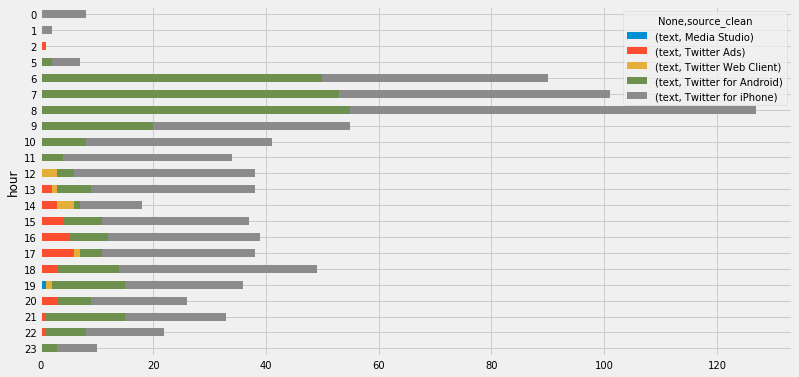

In [98]:
tweetsPerHour = tweets[['source_clean', 'hour', 'text']].pivot_table(
    index='hour', columns=['source_clean'], aggfunc='count')
tweetsPerHour.to_csv('output/tweets-per-hour-of-day.csv')
tweetsPerHour.iloc[::-1].plot(kind='barh', stacked=True)

## Tweets per day

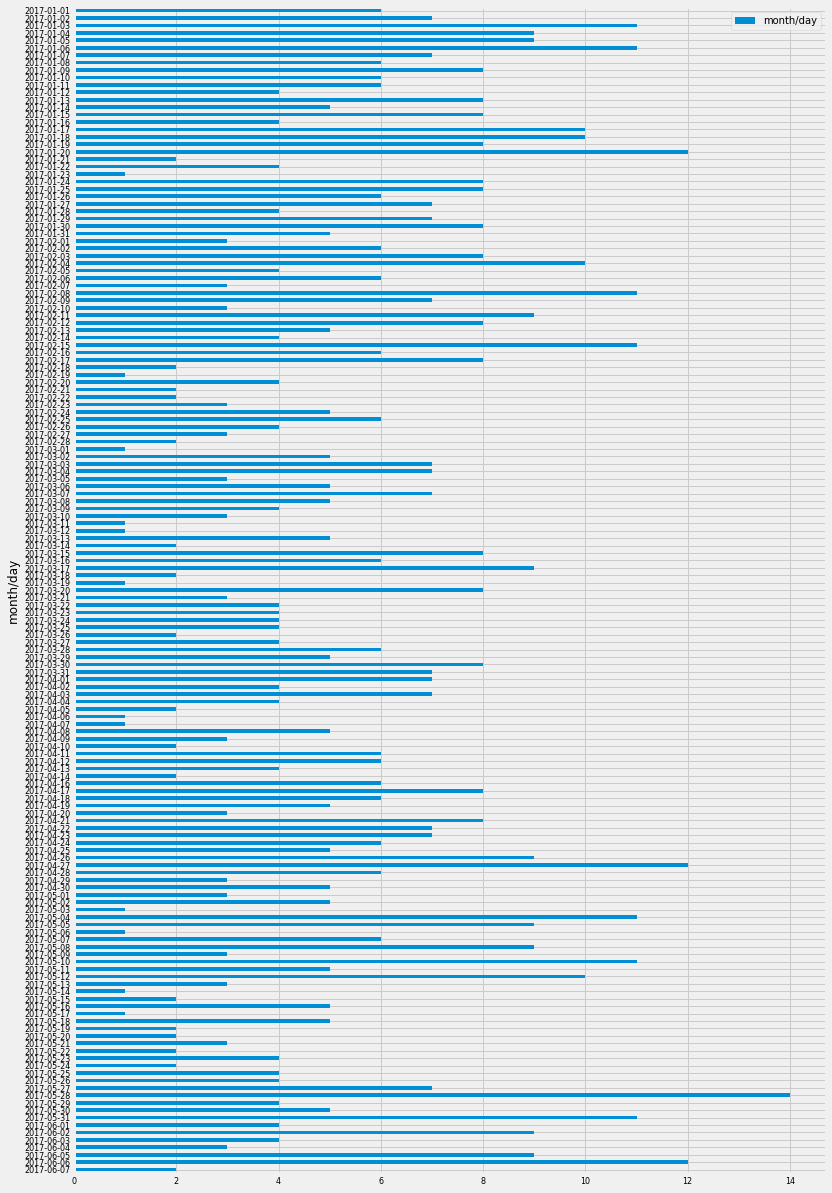

In [99]:
tweetsPerDay = tweets[['month/day']].groupby(tweets['month/day']).count()
tweetsPerDay.iloc[::-1].plot(kind='barh', figsize=(12,20), fontsize=8)

In [100]:
tweetsPerDay.describe()

,month/day
count,157.000000
mean,5.414013
std,2.928736
min,1.000000
25%,3.000000
50%,5.000000
75%,7.000000
max,14.000000


## Tweets per day of week

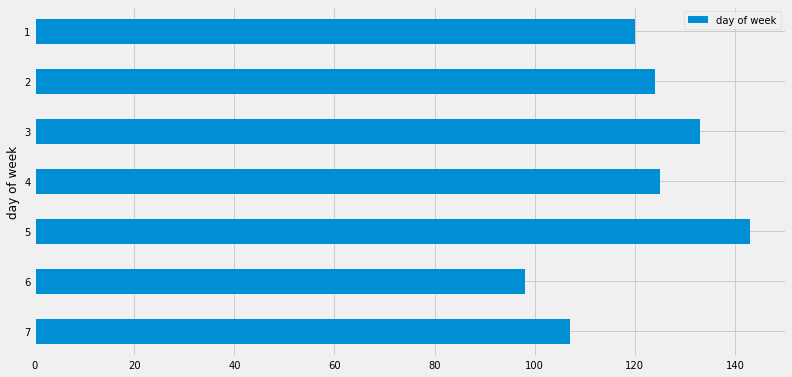

In [101]:
tweetsPerDayOfWeek = tweets[['day of week']].groupby(tweets['day of week']).count()
tweetsPerDayOfWeek.iloc[::-1].plot(kind='barh')

## Tweets per month

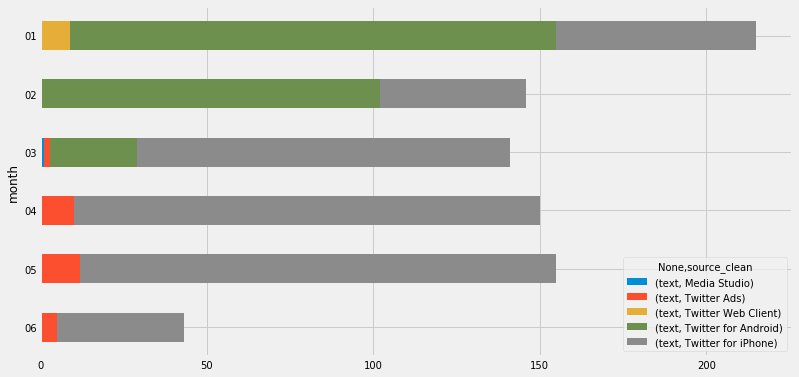

In [102]:
tweetsPerMonth = tweets[['source_clean', 'month', 'text']].pivot_table(index='month', columns=['source_clean'], aggfunc='count')
tweetsPerMonth.iloc[::-1].plot(kind='barh', stacked=True)

## Tweets per week

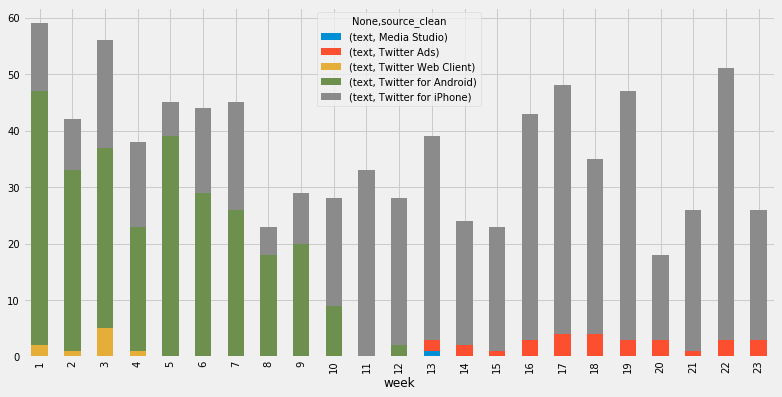

In [103]:
tweetsPerWeek = tweets[['source_clean', 'week', 'text']].pivot_table(index='week', columns=['source_clean'], aggfunc='count')
tweetsPerWeek.to_csv('output/tweetsperweek-by-device.csv', na_rep=0)
tweetsPerWeek.plot(kind='bar', stacked=True)

# Sentiment

We see a significant increase in Trump's "positivity" as measured by VADER (the same algorithm that is used by BOTUS).

_Jupyter is both amazin and stupid... this disabled scrolling to let me loop over plotting._


In [104]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [105]:
sentiment_fields = ['sentiment.compound'] #, 'sentiment.pos', 'sentiment.neg', 'sentiment.neu']

In [106]:
pd.set_option('display.width', 1000)
tweets.sort(columns='sentiment.compound')[['sentiment.compound', 'text']].head()

,sentiment.compound,text
created_date,,
2017-04-18 10:38:59,-0.9735,Democrat Jon Ossoff would be a disaster in Con...
2017-02-07 12:11:29,-0.9370,"I don't know Putin, have no deals in Russia, a..."
2017-01-15 22:46:33,-0.9354,.@NBCNews is bad but Saturday Night Live is th...
2017-02-04 21:44:49,-0.9307,"Because the ban was lifted by a judge, many ve..."
2017-04-09 15:20:39,-0.9245,So sad to hear of the terrorist attack in Egyp...


In [107]:
tweets.sort(columns='sentiment.compound', ascending=False)[['sentiment.compound', 'text']].head()

,sentiment.compound,text
created_date,,
2017-01-01 06:49:49,0.9765,RT @IvankaTrump: 2016 has been one of the most...
2017-01-22 12:35:09,0.9679,Had a great meeting at CIA Headquarters yester...
2017-02-02 11:25:40,0.9674,Attending Chief Ryan Owens' Dignified Transfer...
2017-02-01 03:45:26,0.9666,Hope you like my nomination of Judge Neil Gors...
2017-01-09 11:17:40,0.9600,Rupert Murdoch is a great guy who likes me muc...


In [108]:
tweets.sort(columns=['week', 'sentiment.compound'], ascending=False)[['week', 'sentiment.compound', 'text']].head(40)

,week,sentiment.compound,text
created_date,,,
2017-06-05 20:45:05,23,0.9220,.@SecShulkin's decision is one of the biggest ...
2017-06-06 17:47:33,23,0.7506,Today we remember the courage and bravery of o...
2017-06-07 12:17:13,23,0.7290,"Getting ready to leave for Cincinnati, in the ..."
2017-06-05 10:44:18,23,0.7088,In any event we are EXTREME VETTING people com...
2017-06-05 10:37:59,23,0.6588,The Justice Dept. should ask for an expedited ...
2017-06-07 00:06:50,23,0.6249,Great meeting with @HouseGOP and @SenateGOP le...
2017-06-07 01:07:39,23,0.5411,Senate passed the VA Accountability Act. The H...
2017-06-06 12:15:36,23,0.4215,"Sorry folks, but if I would have relied on the..."
2017-06-06 13:36:50,23,0.4201,So good to see the Saudi Arabia visit with the...


## By month

### Average

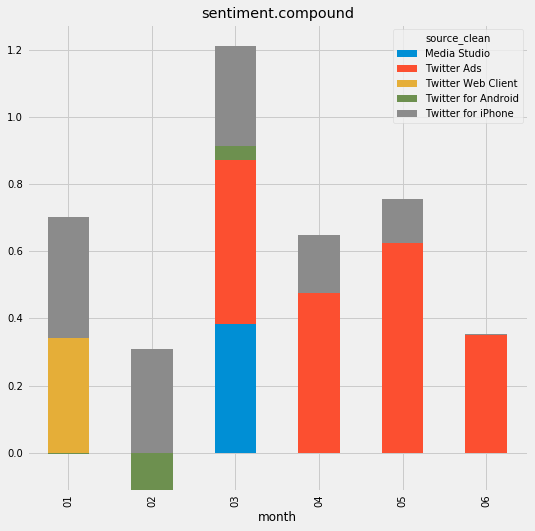

In [109]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'month', field]].pivot_table(index='month', columns='source_clean', values=field, aggfunc='mean')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field, figsize=(8,8))

### Cumulative

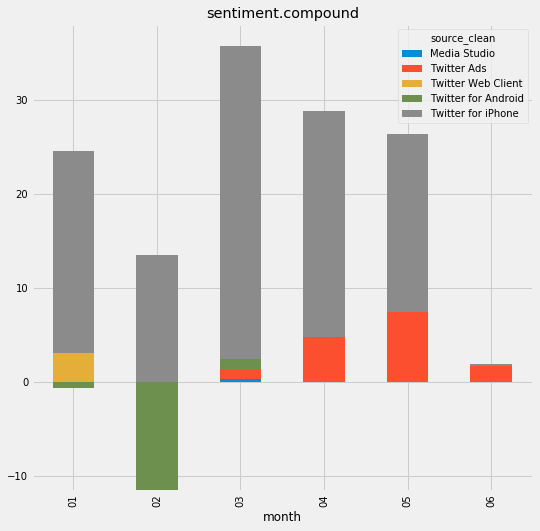

In [110]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'month', field]].pivot_table(index='month', columns='source_clean', values=field, aggfunc='sum')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field, figsize=(8,8))

## By week

### Average

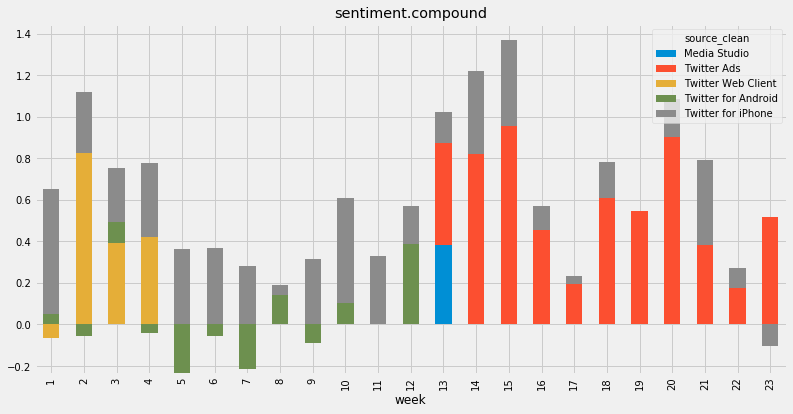

In [111]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'week', field]].pivot_table(index='week', columns='source_clean', values=field, aggfunc='mean')
    sentimentByMonth.to_csv('output/sentiment-by-week-by-device.csv')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

### Cumulative

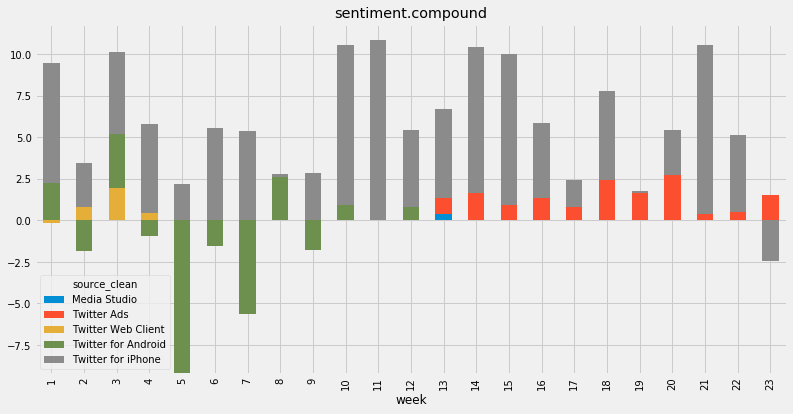

In [112]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'week', field]].pivot_table(index='week', columns='source_clean', values=field, aggfunc='sum')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

### Average, not broken down by device

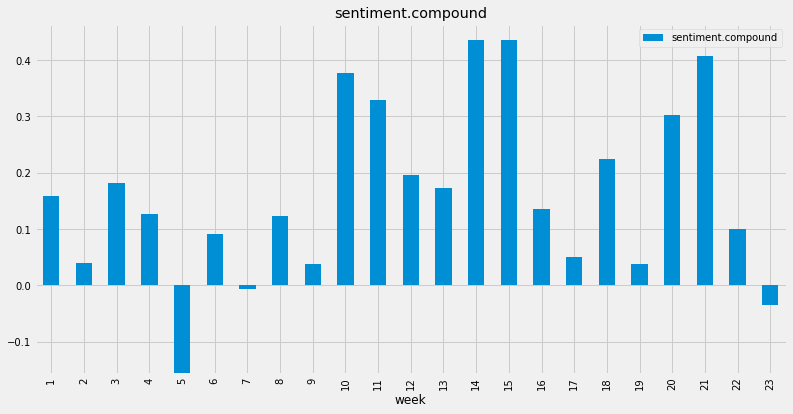

In [113]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['week', field]].groupby('week').mean()
    sentimentByMonth.to_csv('output/sentiment-by-week.csv')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

## Every Tweet's sentiment analysis

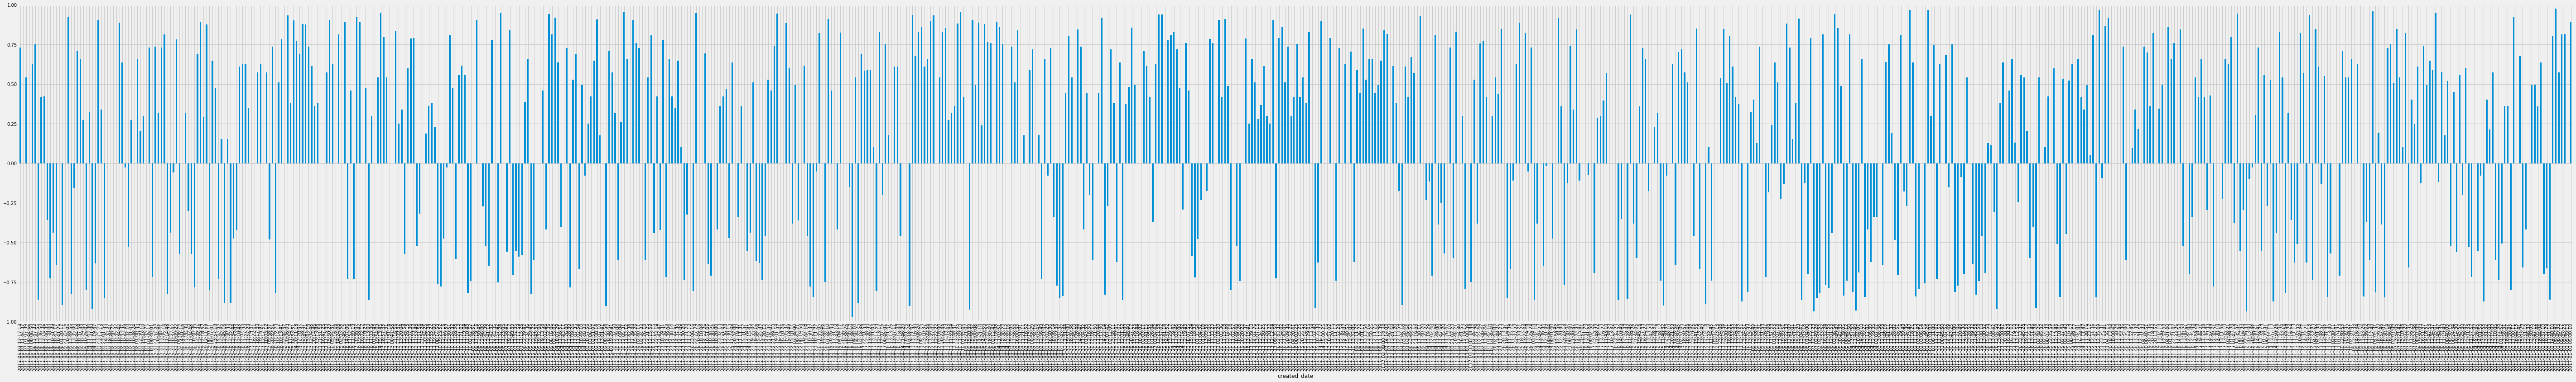

In [114]:
tweets['sentiment.compound'].plot(kind='bar', ylim=[-1,1], figsize=(90,12))

# Follower count

The strange drops in follower count are interesting here. The follower ceiling is strangely lacking in noise.

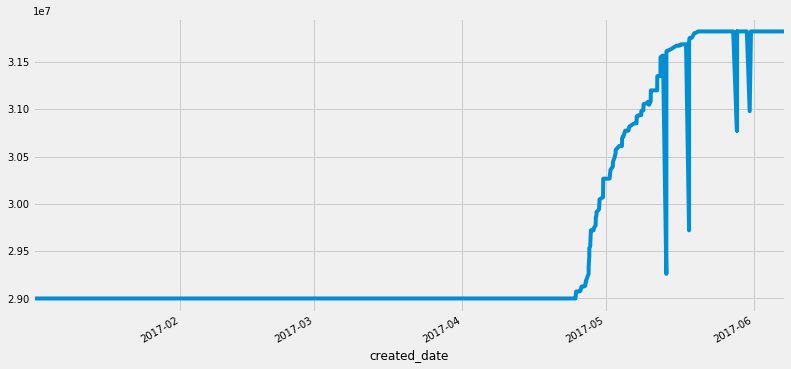

In [115]:
tweets['user.followers_count'].plot()

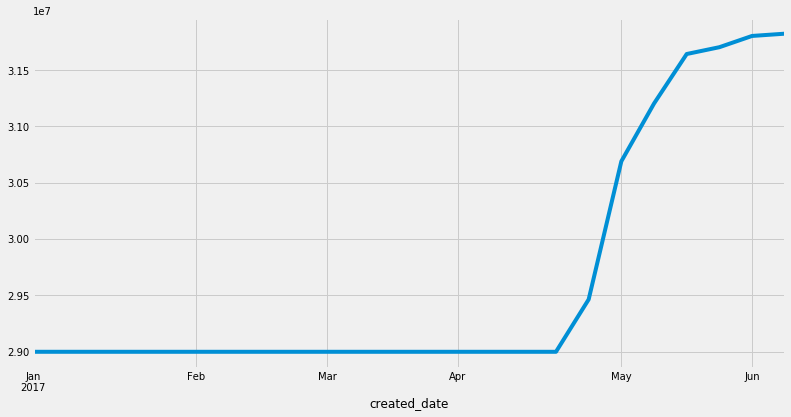

In [116]:
tweets['user.followers_count'].resample('W').plot()

# Per tweet sentiment

In [117]:
sortedSentimentPerTweet = tweets[['week', 'sentiment.compound', 'text', 'id']].sort(['week', 'sentiment.compound'], ascending=False)
# sortedSentimentPerTweet.to_csv('output/sentiment-per-tweet.csv')
sortedSentimentPerTweet

,week,sentiment.compound,text,id
created_date,,,,
2017-06-05 20:45:05,23,0.9220,.@SecShulkin's decision is one of the biggest ...,871830255396192256
2017-06-06 17:47:33,23,0.7506,Today we remember the courage and bravery of o...,872147965451882496
2017-06-07 12:17:13,23,0.7290,"Getting ready to leave for Cincinnati, in the ...",872427222392504320
2017-06-05 10:44:18,23,0.7088,In any event we are EXTREME VETTING people com...,871679061847879682
2017-06-05 10:37:59,23,0.6588,The Justice Dept. should ask for an expedited ...,871677472202477568
2017-06-07 00:06:50,23,0.6249,Great meeting with @HouseGOP and @SenateGOP le...,872243414930264065
2017-06-07 01:07:39,23,0.5411,Senate passed the VA Accountability Act. The H...,872258719404482561
2017-06-06 12:15:36,23,0.4215,"Sorry folks, but if I would have relied on the...",872064426568036353
2017-06-06 13:36:50,23,0.4201,So good to see the Saudi Arabia visit with the...,872084870620520448


In [118]:
df_sortedSentimentPerTweet = sortedSentimentPerTweet.reset_index()
df_sortedSentimentPerTweet['text-encoded'] = df_sortedSentimentPerTweet['text'].apply(encodeText)
df_sortedSentimentPerTweet = df_sortedSentimentPerTweet.drop('text', axis=1)
df_sortedSentimentPerTweet.to_csv('output/df_sortedSentimentPerTweet.csv')

# Text analysis

Common words.

In [119]:
from collections import Counter
import nltk
import string
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bmayes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [120]:
top_N = 100
stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + ['rt']
# RegEx for stopwords
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
# replace '|'-->' ' and drop all stopwords
words = (tweets.text
           .str.lower()
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DF out of Counter
words_data = pd.DataFrame(Counter(words).most_common(300),
                    columns=['Word', 'Frequency']).set_index('Word')

pd.set_option('display.max_rows', top_N)
words_data = words_data.reset_index()
words_data['Word Encoded'] = words_data['Word'].apply(encodeText)
words_data.drop('Word', axis=1).to_csv('output/word-frequencies.csv')
words_data.head(top_N)
#pd.reset_option('display.max_rows')

# plot
# rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

,Word,Frequency,Word Encoded
0,great,125,great
1,&amp;,118,&amp;
2,',74,'
3,-,72,-
4,fake,65,fake
5,!,62,!
6,big,62,big
7,.,57,.
8,",",52,","
9,u..,50,u..


# Specific text searches

In [126]:
from IPython.display import display, Markdown

tweetsEnc = tweets.reset_index()

def analyzeText(search):
    display(Markdown('## Search: _{0}_'.format(search)))
    filtered = tweetsEnc[tweetsEnc['text encoded'].str.contains(search, case=False)]
    count = len(filtered)
    percent = float(len(filtered))/len(tweetsEnc) * 100
    display(Markdown('Number of Tweets: {0}'.format(count)))
    display(Markdown('Percent of all Tweets: {0:.2f}%'.format(percent)))
    analyzedByWeek = filtered[['source_clean', 'week', 'text']].pivot_table(index='week', columns='source_clean', aggfunc='count')
    analyzedByWeek = analyzedByWeek.reindex(range(tweetsEnc['week'].min(), tweetsEnc['week'].max())).fillna(0)
    analyzedByWeek.to_csv('output/word-by-week-{0}.csv'.format(search))
    analyzedByWeekPlot = analyzedByWeek.plot(kind='bar', stacked=True, title='{0} by week'.format(search)) 
    plt.show()
    analyzedByHour = filtered[['source_clean', 'hour', 'text']].pivot_table(index='hour', columns='source_clean', aggfunc='count')
    analyzedByHour = analyzedByHour.reindex(range(0, 24)).fillna(0)
    analyzedByHour.to_csv('output/word-by-hour-{0}.csv'.format(search))
    analyzedByHourPlot = analyzedByHour.plot(kind='bar', stacked=True, title='{0} by hour of day'.format(search))
    plt.show()
    display(Markdown('### The Tweets'))
    for i, row in filtered.iterrows():
        display(Markdown('[{0}](https://twitter.com/realDonaldTrump/status/{2}): {1}'.format(row['human_date'], row['text'], row['id'])))
    display(Markdown('---'))

In [127]:
tweetsEnc

,created_date,contributors,coordinates,created_at,extended_entities.media,favorite_count,favorited,geo,id,id_str,...,user.verified,human_date,month/day,month,day,day of week,hour,week,text encoded,source_clean
0,2017-06-07 12:17:13,None,None,Wed Jun 07 12:17:13 +0000 2017,NaN,32541,False,None,872427222392504320,872427222392504320,...,True,"Wednesday, Jun 7, 2017 8:17 AM",2017-06-07,06,7,3,8,23,"Getting ready to leave for Cincinnati, in the ...",Twitter for iPhone
1,2017-06-07 11:44:37,None,None,Wed Jun 07 11:44:37 +0000 2017,NaN,38860,False,None,872419018799550464,872419018799550464,...,True,"Wednesday, Jun 7, 2017 7:44 AM",2017-06-07,06,7,3,7,23,"I will be nominating Christopher A. Wray, a ma...",Twitter for iPhone
2,2017-06-07 01:07:39,None,None,Wed Jun 07 01:07:39 +0000 2017,NaN,70513,False,None,872258719404482561,872258719404482561,...,True,"Tuesday, Jun 6, 2017 9:07 PM",2017-06-06,06,6,2,21,23,Senate passed the VA Accountability Act. The H...,Twitter for iPhone
3,2017-06-07 00:44:56,None,None,Wed Jun 07 00:44:56 +0000 2017,NaN,26478,False,None,872253002266161153,872253002266161153,...,True,"Tuesday, Jun 6, 2017 8:44 PM",2017-06-06,06,6,2,20,23,#ICYMI: Announcement of Air Traffic Control In...,Twitter for iPhone
4,2017-06-07 00:06:50,None,None,Wed Jun 07 00:06:50 +0000 2017,NaN,30933,False,None,872243414930264065,872243414930264065,...,True,"Tuesday, Jun 6, 2017 8:06 PM",2017-06-06,06,6,2,20,23,Great meeting with @HouseGOP and @SenateGOP le...,Twitter Ads
5,2017-06-06 17:47:33,None,None,Tue Jun 06 17:47:33 +0000 2017,NaN,84840,False,None,872147965451882496,872147965451882496,...,True,"Tuesday, Jun 6, 2017 1:47 PM",2017-06-06,06,6,2,13,23,Today we remember the courage and bravery of o...,Twitter for iPhone
6,2017-06-06 13:44:55,None,None,Tue Jun 06 13:44:55 +0000 2017,NaN,59849,False,None,872086906804240384,872086906804240384,...,True,"Tuesday, Jun 6, 2017 9:44 AM",2017-06-06,06,6,2,9,23,"...extremism, and all reference was pointing t...",Twitter for iPhone
7,2017-06-06 13:36:50,None,None,Tue Jun 06 13:36:50 +0000 2017,NaN,59203,False,None,872084870620520448,872084870620520448,...,True,"Tuesday, Jun 6, 2017 9:36 AM",2017-06-06,06,6,2,9,23,So good to see the Saudi Arabia visit with the...,Twitter for iPhone
8,2017-06-06 12:15:36,None,None,Tue Jun 06 12:15:36 +0000 2017,NaN,93500,False,None,872064426568036353,872064426568036353,...,True,"Tuesday, Jun 6, 2017 8:15 AM",2017-06-06,06,6,2,8,23,"Sorry folks, but if I would have relied on the...",Twitter for iPhone
9,2017-06-06 12:06:35,None,None,Tue Jun 06 12:06:35 +0000 2017,NaN,69790,False,None,872062159789985792,872062159789985792,...,True,"Tuesday, Jun 6, 2017 8:06 AM",2017-06-06,06,6,2,8,23,During my recent trip to the Middle East I sta...,Twitter for iPhone


## Search: _great_

Number of Tweets: 135

Percent of all Tweets: 15.88%

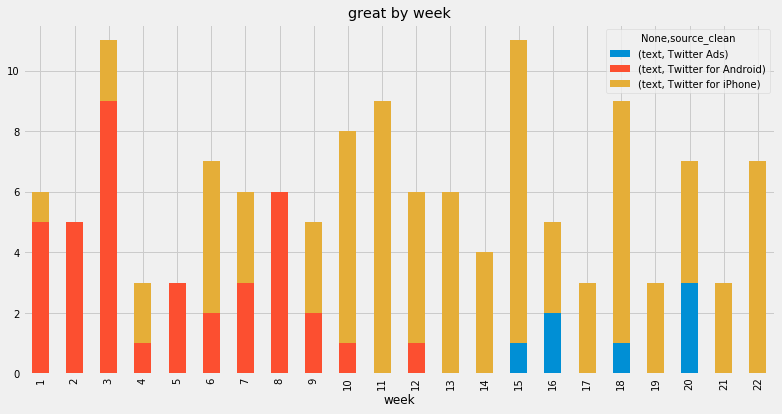

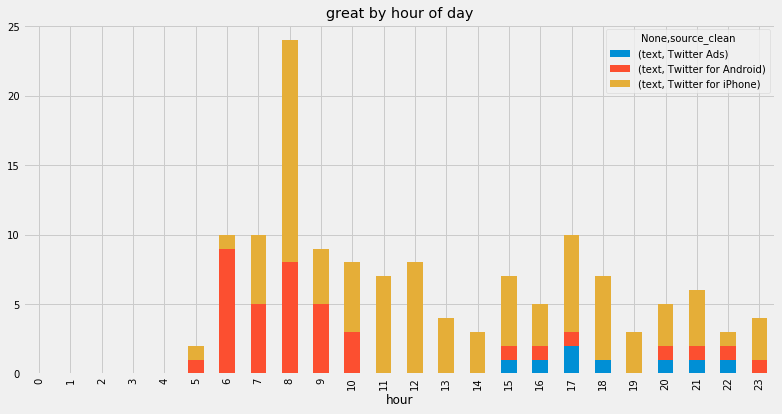

### The Tweets

[Wednesday, Jun 7, 2017 8:17 AM](https://twitter.com/realDonaldTrump/status/872427222392504320): Getting ready to leave for Cincinnati, in the GREAT STATE of OHIO, to meet with ObamaCare victims and talk Healthcare &amp; also Infrastructure!

UnicodeEncodeError: 'ascii' codec can't encode character u'\u2026' in position 115: ordinal not in range(128)

In [128]:
searches = ['great', 'fake', 'mexic', 'fox', 'terror', 'ivanka', 'ms 13', 'russia', 'failing', 'election']
for search in searches:
    analyzeText(search)